## 0. 今日の量子コンピュータの問題

- Noisy Intermediate-Scale Quantum (NISQ) デバイス
    - 量子回路が深くなる（ゲート数が多くなる）ほど、誤差が大きくなる
    - 十分な量子ビット数ではない
- 量子ビットが全結合でない量子デバイスもある
- 各社が開発している量子デバイスに対して、量子ソフトウェアツールキットが用意されてる


### 0-1. TKETとは
- Quantum Software Development Kit
- C++で実装
- pythonモジュール　`pytket`で利用可能
- 最適化コンパイラ：　ユーザーフレンドリーな回路→量子デバイスで実行可能な回路に変換可能
    - Language-agnostic (多くの量子回路をプログラミングするフレームワーク(qiskit, Cirq, etc)をサポート)
    - Retagetable (多くの量子デバイス(IBM, Honeywell, etc)をサポート)
    - Circuit Optimisation (量子計算時に生じるデバイスエラーの影響を最小化。デバイス依存＆デバイス非依存のものが実装)
    
<img src="./fig/tket1.png" width="750">


参照
- [pytket ドキュメント](https://cqcl.github.io/tket/pytket/api/index.html)
- [pytket ユーザーマニュアル](https://cqcl.github.io/pytket/manual/index.html)
- [t|ket⟩ : A Retargetable Compiler for NISQ Devices](https://arxiv.org/abs/2003.10611)

### 0-2. 今回必要となる python、python パッケージ
* Python 3.8 or higher (Python 3.9.7で動作確認をしています。)

|  パッケージ （version） |  概要  |
| :---- | :---- |
|  pytket==1.0.1  |  tketを利用するためのpython モジュール |
|  pytket-qiskit==0.23.0  |  qiskitを利用するためのpytket-extension  |
|  pytket-braket==0.17.0  |  Amazon Braketを利用するためのpytket-extension  |
|  pytket-qsharp==0.23.0  |  Azure Quantumを利用するためのpytket-extension  |
|  pytket-qulacs==0.17.0  |  Qulacsを利用するためのpytket-extension  |

* pytket-qsharpのパッケージは.net等のインストールが必要です。詳しくは[pytket-qsharpドキュメント](https://cqcl.github.io/pytket-extensions/api/qsharp/index.html#http://)をご確認ください。

<img src="fig/tket2.png" width="750">

環境にインストールされていない場合は、以下のセルの＃を取り除き、インストールしてください。

In [16]:
#!pip install pytket==1.0.1
#!pip install pytket-qiskit==0.23.0
#!pip install --upgrade --force-reinstall pytket-braket==0.17.0
#!pip install pytket-qsharp==0.23.0
#!pip install pytket-qulacs==0.17.0
#!pip install pylatexenc #可視化のためのパッケージ

## 1. 量子回路を作成
ここでは IBMの量子デバイスやシュミレーションを利用できる`qiskit`と`tket`でベル状態を作成する。

### 1-1. `qiskit`でベル状態を作成
$$ |\Psi\rangle = \frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$$

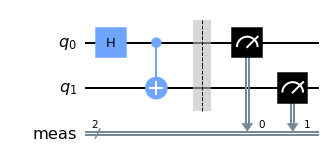

In [17]:
from qiskit import QuantumCircuit

qs_bell = QuantumCircuit(2)
qs_bell.h(0)
qs_bell.cx(0,1)
qs_bell.measure_all()

qs_bell.draw(output='mpl')

In [18]:
#from qiskit.tools.visualization import circuit_drawer
#circuit_drawer(qs_bell, output='mpl')

### 1-2. IBMが提供しているローカルシミュレータで計算

In [5]:
from qiskit import Aer
from qiskit.visualization import plot_histogram

In [6]:
#Aer.backends()

In [7]:
ibm_sim = Aer.get_backend('aer_simulator')

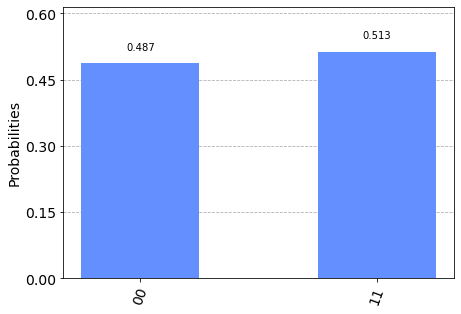

In [8]:
handle = ibm_sim.run(qs_bell, shots=1000)
counts = handle.result().get_counts()
plot_histogram(counts)

### 1-3. `tket`でベル状態を作成

In [9]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter

bell = Circuit(2)
bell.H(0).CX(0,1)
bell.measure_all()

render_circuit_jupyter(bell)

### 1-4. `pytket-qiskit`でIBMが提供しているローカルシミュレータで計算

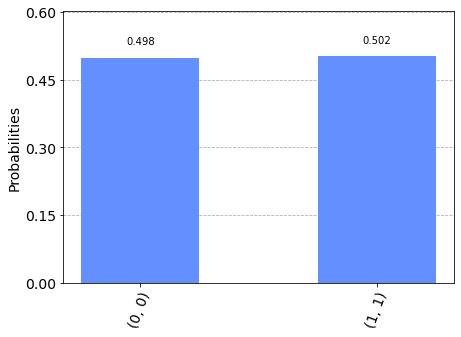

In [10]:
from pytket.extensions.qiskit import AerBackend
backend = AerBackend()

handle = backend.process_circuit(bell, n_shots =1000)
result_counts = backend.get_result(handle).get_counts()
plot_histogram(result_counts)

## 2. 量子回路の変換
pytketでは
- qiskitで記述した量子回路からtketの量子回路のクラスに変換が可能
- tketで記述した量子回路からqiskitの量子回路のクラスに変換が可能
- tketで記述した量子回路と他の量子回路をプログラミングするフレームワークでの量子回路の交換が可能

参照：[pytket-extensions](https://cqcl.github.io/pytket-extensions/api/index.html) 

### 2-1. `qiskit`の量子回路から`tket`の量子回路に変換

In [11]:
from pytket.extensions.qiskit import qiskit_to_tk

In [12]:
bell2 = qiskit_to_tk(qs_bell)
bell2

[H q[0]; CX q[0], q[1]; Barrier q[0], q[1]; Measure q[0] --> meas[0]; Measure q[1] --> meas[1]; ]

In [13]:
render_circuit_jupyter(bell2)

### 2-2. `tket`の量子回路から`qiskit`の量子回路に変換

In [14]:
from pytket.extensions.qiskit import tk_to_qiskit

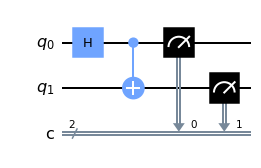

In [15]:
qs_bell2 = tk_to_qiskit(bell)
qs_bell2.draw('mpl')

In [16]:
#from pytket.extensions.braket import tk_to_braket
#tk_to_braket(bell)

## 3. 量子回路の最適化
例えば、Hゲートを同じビットに連続して作用させるとゲート操作をしていない恒等な量子状態が得られます。
<img src="fig/circ.png" width="500">

量子回路が深くなる（ゲート数が多くなる）ほど、誤差が大きくなるNISQ デバイスでは左辺のような状況は除去したい。

その他にも下記のような恒等な関係があります。

<img src="fig/relation.png" width="700">

### 3-1. PauliSimp 関数を利用した、量子回路の最適化
tketには量子回路を最適化する様々な機能が用意されている。
ここでは、PauliSimp 関数を利用した回路の最適化を行う。

（PauliSimp 関数：Pauli ゲートとCliffordゲートで表現された量子回路を出力）

ランダムな量子回路を作成し、回路の深さとCXの深さを数える。

In [17]:
from pytket.pauli import Pauli
from pytket.circuit import PauliExpBox, fresh_symbol, OpType
from pytket.passes import DecomposeBoxes
box = PauliExpBox([Pauli.I, Pauli.Z, Pauli.X, Pauli.Y], fresh_symbol('tm'))
from pytket.utils import Graph
import numpy as np

def get_random_pauli_gadgets(n_qubits, n_pauli_gadgets, max_entangle):
    """ """
    paulis = [Pauli.I, Pauli.X, Pauli.Y, Pauli.Z]
    circ = Circuit(n_qubits)
    for i in range(n_pauli_gadgets):
        ls_paulis = [np.random.choice(paulis) for k in range(max_entangle)]
        if ls_paulis.count(Pauli.Y) % 2 == 0:
            continue
        if len(ls_paulis) - ls_paulis.count(Pauli.I) <= 1:
            continue
        qubits = np.random.choice(
            [i for i in range(n_qubits)], size=max_entangle, replace=False
        )
        box = PauliExpBox(ls_paulis, fresh_symbol('a'))
        circ.add_pauliexpbox(box, sorted(qubits))
    DecomposeBoxes().apply(circ)
    return circ

circ = get_random_pauli_gadgets(
    n_qubits=8, n_pauli_gadgets=300, max_entangle=5
)
print('Circuit depth: ', circ.depth())
print('CX depth: ', circ.depth_by_type(OpType.CX))
render_circuit_jupyter(circ)

Circuit depth:  1092
CX depth:  746


PauliSimp 関数を使って、量子回路の最適化

In [18]:
# Circuit optimization by using compiler passes.
from pytket.passes import PauliSimp
circx = circ.copy()
PauliSimp().apply(circx)
print('Circuit depth: ', circx.depth())
print('CX depth: ', circx.depth_by_type(OpType.CX))
#render_circuit_jupyter(circx)

Circuit depth:  916
CX depth:  591


## 4. pytket-extensionで、IBM Quantum、Amazon Braket、Azure Quantum、Qulacsを利用
- 下記のスクリプトはそれぞれのクラウドで<span style="color: red; ">有料の操作</span>となることがありますので、ご注意ください

### 4-1. pytket-qiskitを利用して、IBM Quantumのシミュレータや実機にアクセス

In [3]:
path = 'ibm-token'
f = open(path)
ibm_token = f.read()
f.close()
from pytket.extensions.qiskit.backends.config import set_ibmq_config
set_ibmq_config(ibmq_api_token=ibm_token)

In [4]:
from pytket.extensions.qiskit import IBMQBackend, IBMQEmulatorBackend
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter

In [5]:
#ibm_backend = IBMQBackend("ibmq_lima")
#ibm_backend = IBMQBackend("ibmq_qasm_simulator")
# AerBackend to emulate the behaviour of IBMQBackend. Requires a valid IBMQ account.
ibm_backend = IBMQEmulatorBackend("ibmq_lima")

In [6]:
bell = Circuit(2)
bell.H(0).CX(0,1)
bell.measure_all()
render_circuit_jupyter(bell)

# backendのgate setで量子回路を表現する
ibm_bell = ibm_backend.get_compiled_circuit(bell)
render_circuit_jupyter(ibm_bell)

In [7]:
ibm_handle = ibm_backend.process_circuit(ibm_bell, n_shots =1000)

In [8]:
ibm_result = ibm_backend.get_result(ibm_handle)

In [9]:
#ibm_backend.cancel(ibm_handle)

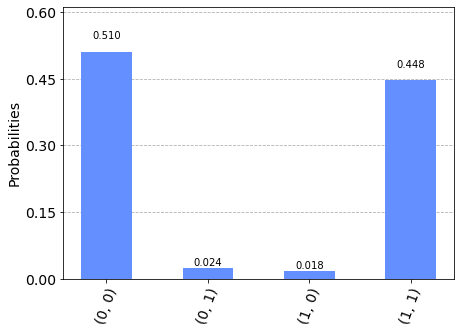

In [10]:
from qiskit.visualization import plot_histogram
plot_histogram(ibm_result.get_counts())

### 4-2. pytket-braketを利用して、Amazon Braketのシミュレータや実機にアクセス

In [11]:
#フォルダーにアクセスキー等の情報ファイルaws-keyを作成し、読み込む
path = 'aws-key'
f = open(path)
aws_access_key_id, aws_secret_access_key, s3_name, bucket_key= [s.strip() for s in f.readlines()]
f.close()

In [12]:
#Braket clientを作成し、Sessionを開始するところで"No module named 'braket.device_schema.oqc'"のエラーが出た場合には,amazon-braket-schemasをアップグレード
#!pip install --upgrade amazon-braket-schemas

In [13]:
# Braket clientを作成し、Sessionを開始
import boto3
from braket.aws import AwsSession
boto_session = boto3.Session(
    aws_access_key_id= aws_access_key_id,
    aws_secret_access_key= aws_secret_access_key,
    region_name= 'eu-west-2'
)
aws_session = AwsSession(boto_session=boto_session)

In [14]:
#aws_session.search_devices()

In [19]:
# backend の選択
from pytket.extensions.braket import BraketBackend

# ionQ   arn:aws:braket:::device/qpu/ionq/ionQdevice, region: us-east-1
# aws_backend = BraketBackend(device='ionQdevice', s3_bucket=s3_name , s3_folder = bucket_key, device_type = 'qpu', provider = 'ionq', aws_session=aws_session)
# Aspen-11   arn:aws:braket:::device/qpu/rigetti/Aspen-11 #Aspen-11, region: us-west-1
# aws_backend = BraketBackend(device='Aspen-11', s3_bucket=s3_name , s3_folder = bucket_key, device_type = 'qpu', provider = 'rigetti', aws_session=aws_session)
# Aspen-M-1   arn:aws:braket:::device/qpu/rigetti/Aspen-11 #Aspen-11, region: us-west-1
# aws_backend = BraketBackend(device='Aspen-M-1',region = 'us-west-1', s3_bucket=s3_name , s3_folder = bucket_key, device_type = 'qpu', provider = 'rigetti', aws_session=aws_session)
# Oxford Lucy   arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy #Lucy, region: eu-west-2
# aws_backend = BraketBackend(device='Lucy',region = 'eu-west-2', s3_bucket=s3_name , s3_folder = bucket_key, device_type = 'qpu', provider = 'oqc', aws_session=aws_session)
# SV1    sim_arn = 'arn:aws:braket:::device/quantum-simulator/amazon/sv1'     #SV1, region:
# aws_backend = BraketBackend(device='sv1', s3_bucket=s3_name , s3_folder = bucket_key, aws_session=aws_session)
# TN1   sim_arn = 'arn:aws:braket:::device/quantum-simulator/amazon/tn1'    #TN1, region: us-west-2, us-east-1
# aws_backend = BraketBackend(device='tn1', s3_bucket=s3_name , s3_folder = bucket_key, device_type = 'quantum-simulator', provider = 'amazon', aws_session=aws_session)
# DM1   'arn:aws:braket:::device/quantum-simulator/amazon/dm1'    #DM1, region: 
# aws_backend = BraketBackend(device='dm1', s3_bucket=s3_name , s3_folder = bucket_key, device_type = 'quantum-simulator', provider = 'amazon', aws_session=aws_session)

aws_backend = BraketBackend(local=True)


In [16]:
# bell状態の作成
bell = Circuit(2)
bell.H(0).CX(0,1)
render_circuit_jupyter(bell)

# bell状態をbackendのgate setで量子回路を表現する
aws_bell = aws_backend.get_compiled_circuit(bell)
render_circuit_jupyter(aws_bell)

In [17]:
aws_handle = aws_backend.process_circuit(aws_bell, n_shots =1000)

In [18]:
aws_result = aws_backend.get_result(aws_handle)
print(aws_result.get_counts())

Counter({(1, 1): 512, (0, 0): 488})


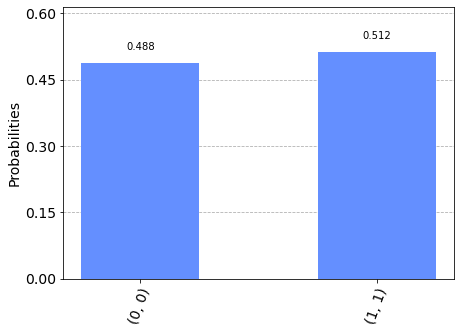

In [19]:
counts = aws_result.get_counts()
plot_histogram(counts)

### 4-3. pytket-qsharpを利用して、Azure Quantumのシミュレータや実機にアクセス

In [1]:
path = 'azure-key'
f = open(path)
resource_id = [s.strip() for s in f.readlines()]
f.close()

In [2]:
from pytket.extensions.qsharp import set_azure_config
set_azure_config(resourceId=resource_id, location="eastus")

In [3]:
from pytket.extensions.qsharp import AzureBackend

In [4]:
# Azure Qauntum上の実機IonQを利用する
#from pytket.extensions.qsharp import AzureBackend
#azure_backend = AzureBackend(target_name='ionq.simulator')

In [5]:
# Azure Qauntumが提供しているローカルシミュレータを利用する
from pytket.extensions.qsharp import QsharpSimulatorBackend
from qiskit.visualization import plot_histogram

In [6]:
azure_backend = QsharpSimulatorBackend()

In [7]:
from pytket import Circuit
from pytket.circuit.display import render_circuit_jupyter
bell = Circuit(2)
bell.H(0).CX(0,1)
bell.measure_all()
render_circuit_jupyter(bell)

# backendのgate setで量子回路を表現する
azure_bell = azure_backend.get_compiled_circuit(bell)
render_circuit_jupyter(azure_bell)

In [8]:
result = azure_backend.process_circuit(azure_bell, n_shots=1000)

In [9]:
azure_result = azure_backend.get_result(result)
azure_counts = azure_result.get_counts()
azure_counts

Counter({(0, 0): 492, (1, 1): 508})

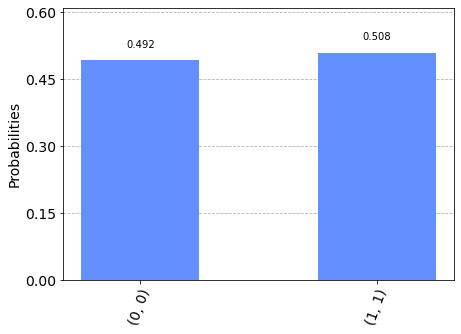

In [10]:
plot_histogram(azure_counts)

### 4-4. pytket-qulacs を利用して、Qulacsのシミュレータにアクセス

In [105]:
from pytket.extensions.qulacs import QulacsBackend
qulacs_backend = QulacsBackend()

In [111]:
# bell状態の作成
bell = Circuit(2)
bell.H(0).CX(0,1)
bell.measure_all()

render_circuit_jupyter(bell)

# backendのgate setで量子回路を表現する
qulacs_bell = qulacs_backend.get_compiled_circuit(bell)
render_circuit_jupyter(qulacs_bell)

In [113]:
qulacs_handle = qulacs_backend.process_circuit(qulacs_bell, n_shots=1000)

In [114]:
qulacs_result = qulacs_backend.get_result(qulacs_handle)
print(qulacs_result.get_counts())

Counter({(0, 0): 506, (1, 1): 494})


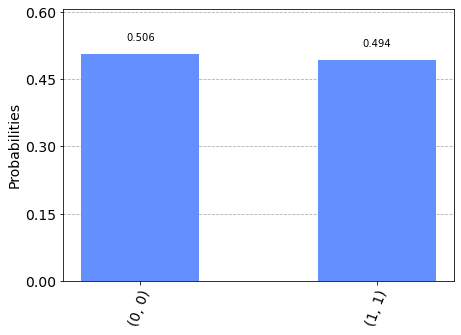

In [115]:
counts = qulacs_result.get_counts()
plot_histogram(counts)

スクリプトに関してのお問い合わせは以下までお願いいたします。
- 問い合わせ先（ 日本語 ）: cqcjapan.business@cambridgequantum.com


弊社のご紹介
- ウェブサイト（ 英語 ）： https://cambridgequantum.com/
- 各種技術詳細： https://cambridgequantum.com/our-technology/
- 学術論文： https://cambridgequantum.com/our-publications/　
- プレスリリース（ 日本語 ）： https://japan.zdnet.com/company/30001168/release/　
- Twitter（ 日本語 ）： https://twitter.com/cqc_japan
- CQ日本チーム主催の勉強会（ 日本語 ）： https://cambridgequantum.connpass.com/
- 採用情報（ 日本語 ）：https://jobs.eu.lever.co/cambridgequantum?location=Tokyo
- 問い合わせ先（ 日本語 ）: cqcjapan.business@cambridgequantum.com
